## Install ta-lib from source (slow af)

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

## Install ta-lib from binary

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 9.8MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp37-cp37m-linux_x86_64.whl size=1437948 sha256=c7e9bbe266da7e084b1fa722d83392cde368b3f94241f33bba4d25cc78f2f817
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [ ]:
!pip install websocket_client
!pip install python-binance
!pip install seaborn

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 3.1MB 10.2MB/s 
     |████████████████████████████████| 501kB 26.3MB/s 
     |████████████████████████████████| 286kB 40.7MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 3.2MB 35.0MB/s 
     |████████████████████████████████| 184kB 42.6MB/s 
     |████████████████████████████████| 245kB 39.0MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 


## Defaults

In [ ]:
## Setup
symbol1 = 'BTT'
symbol2 = 'BUSD'
symbol = symbol1+symbol2
symbols = [symbol]
# path = 'data/ETHBUSD_1m.csv'
local = True
# start_str = '1 month ago'


## Strategy thresholds

In [ ]:
 
limit = 8192
 
RSI_LOW = 30
RSI_HIGH = 60
 
STOCH_LOW = 20
STOCH_HIGH = 80
 
# STOCHRSI_LOW = 20
# STOCHRSI_HIGH = 60
 
# ULTOSC_LOW = 30
# ULTOSC_HIGH = 70
 
# MOM_LOW = 20
# MOM_HIGH = 100

## Binance constants and imports

In [ ]:
BASE_URL = 'https://api.binance.com/api'
BASE_TEST_URL = 'https://testnet.binance.vision/api'
WSS_URL = 'wss://stream.binance.com:9443/ws'

API_KEY = 'paste_here'
SECRET_API_KEY = 'paste_here'


BUY = 1
SELL = -1
WAIT = 0
last_action = WAIT

# import config
import seaborn as sns
import websocket
import numpy as np
import pandas as pd
from talib import *
import csv, json
import time, datetime
from binance.client import Client
from binance.enums import *
import matplotlib


## Developement options

In [ ]:
websocket.enableTrace(True)
matplotlib.rcParams['figure.figsize'] = (32, 8)
np.set_printoptions(precision=4)

## Client creation and globals

In [ ]:
client = Client(API_KEY,SECRET_API_KEY)

# columns=['time_series','open','high','low','close','volume']
opens,highs,lows,closes,volumes = [],[],[],[],[]
timestamps = []
indicators = []
sim_buy = []
sim_sell = []
simulated_change = 0
multiplier =2
signals = []


## Logic/strategies

### Indicators implementations
because fuck talib and lack of any fucking documentation

In [ ]:
def ichimoku(highs,lows,closes,a=9,b=26,c=52,d=26):
    highs = pd.Series(highs)
    lows = pd.Series(lows)
    closes = pd.Series(closes)
    tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span=[],[],[],[],[]
    
    a_period_high = highs.rolling(a).max()
    a_period_low = lows.rolling( a).min()
    # print(a_period_high,a_period_low)
    tenkan_sen = (a_period_high + a_period_low) / 2
    # print(tenkan_sen)
    b_period_high = highs.rolling(b).max()
    b_period_low = lows.rolling(b).min()
    kijun_sen = (b_period_high + b_period_low) / 2
 
    senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
 
    c_period_high = highs.rolling(c).max()
    c_period_low = lows.rolling(c).min()
    senkou_span_b = ((c_period_high + c_period_low) / 2).shift(26)
 
    chikou_span = closes.shift(-d)
 
    # print(tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span)
    return tenkan_sen.to_numpy(), kijun_sen.to_numpy(), senkou_span_a.to_numpy(), senkou_span_b.to_numpy(), chikou_span.to_numpy()

def childsplay(value,window=2,shift=1):
    current,future = SMA(value,window),SMA(value,window)
    future = np.concatenate((np.array(np.nan), future), axis=None)
    sns.lineplot(x=range(0,len(current)),y=current)
    sns.lineplot(x=range(0,len(future)),y=future)
    return current,future

def SMAS(value,window=2,shift=1):
    current,future = SMA(value,window),SMA(value,window)
    future = np.roll(future,1)
    # sns.lineplot(x=range(0,len(current)),y=current)
    # sns.lineplot(x=range(0,len(future)),y=future)
    return current,future



### Logic

In [ ]:
def cross(a,b):
    '''a goes above b after being below it'''
    try:
        if a[-2]<b[-2] and a[-1] > b[-1]:
            return True
        else:
            return False
    except IndexError:
        return False

def rolling_stop(values,percent=1,window=10):
    global stop
    try:
        v = values[-1]
        # vs = SMA(values,window)
        vmx = MAX(values,window)
        stop = vmx*((100-percent)/100) 
        print(stop)
    except:
        print(stop)
        pass
      
def logic(opens,highs,lows,closes,volumes,signal):
    global tempk, tempd,gts,gks,gssa,gssb,gcs, hst
    tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span = ichimoku(highs,lows,closes)
    macd, macdsignal, macdhist = MACD(closes, fastperiod=12, slowperiod=26, signalperiod=9)
    ma1,ma2=SMA(closes,60),SMA(closes,60)
    ma2.roll(15)
    
    fastk, fastd = STOCHF(highs,lows,closes, fastk_period=14, fastd_period=3, fastd_matype=0)
    
    # signal.append(stop_loss(closes))
 
    try:
        ts,ks,ssa,ssb,cs = tenkan_sen[-1], kijun_sen[-1], senkou_span_a[-26], senkou_span_b[-26], chikou_span[-1]
        pts,pks,pssa,pssb,pcs = tenkan_sen[-2], kijun_sen[-2], senkou_span_a[-27], senkou_span_b[-27], chikou_span[-2]
        gts,gks,gssa,gssb,gcs = tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span
        hist = macdhist[-1]
        hst = macdhist
    
    except IndexError:
        pass
    return signal

## Order creation

In [ ]:

def test_order(side,quantity,price,symbol,order_type=ORDER_TYPE_LIMIT):
    try:
        #print('sending order...')
        client.create_test_order(symbol=symbol,
                                 side=side,
                                 type=order_type,
                                 timeInForce=TIME_IN_FORCE_GTC,
                                 quantity=quantity,
                                 price=str(price))
        print(side,quantity,symbol,order_type,'at ',price)
    except Exception as e:
        print("an expection occurred - {}".format(e))
        return False
    return True

def order(side, quantity, price, symbol, order_type = ORDER_TYPE_LIMIT):
    try:
        #print('sending order...')
        client.create_order(symbol=symbol,
                                 side=side,
                                 type=order_type,
                                 timeInForce=TIME_IN_FORCE_GTC,
                                 quantity=quantity,
                                 price=str(price))
        print(side,quantity,symbol,order_type,'at ',price)
    except Exception as e:
        print("an expection occurred - {}".format(e))
        return False
    return True


## Additional mechanics

In [ ]:
def overview():
    global sim_buy,sim_sell
    result = 0
    for  i in range(len(sim_buy)):
        try:
            result += (sim_sell[i]/1.001-(sim_buy[i]*1.001))/sim_buy[i]*100
        except:
            pass

    try:
        print(f'Overall oucome: {round(result,3)}%, Last: {round((sim_sell[i]/1.001-(sim_buy[i]*1.001))/sim_buy[i]*100,3)}')
    except:
        pass

 
def get_balance(client):
    df = client.get_account()
    df = pd.DataFrame(df['balances'])
    df.free = df['free'].astype(float)
    df.locked = df['locked'].astype(float)
    df = df.set_index('asset')
    return df


def calculate_quantity(price,balance,info):
   
    # balancu = balance.loc[symbol]['free']
    # print(b1,b2)
    qty = (balance*price)-((balance*price) % float(info['step_size']))
    return qty

def min_order_check(quantity,info):
    if quantity > info['min_price']:
        return True
    else:
        print('U too poor mah boi')
        return False

def get_info(client,sym):
    info = client.get_symbol_info(sym)


    min_price = info['filters'][3]['minNotional']
    step_size = info['filters'][2]['stepSize']
    info = {'min_price':min_price,'step_size':step_size}
    return info

## Realtime mode

In [ ]:

def on_open(ws):
    global opens,highs,lows,closes,volumes
    print('Connection initialized')
    for s in range(len(symbols)):
        symbols[s]=symbols[s].lower()+'@kline_1m'
    payload = json.dumps({
    "method": "SUBSCRIBE",
    "params": symbols,
    "id": 1
    })
    print(payload)
    ws.send(payload)
    print(f'Prefetching {symbol} data...')
    candles = client.get_klines(symbol=symbol, interval=KLINE_INTERVAL_1MINUTE)
    for kline in candles:
        opens.append(float(kline[1]))
        highs.append(float(kline[2]))
        lows.append(float(kline[3]))
        closes.append(float(kline[4]))
        volumes.append(float(kline[5]))

def on_close(ws):
    print('Connection closed')

def on_error(ws, error):
    print(f'Shutting down {error}')

def on_message(ws, message):
    global opens,highs,lows,closes,volumes,last_action,sim_buy,sim_sell,symbol1,symbol2

    signal = []

    info = get_info(client,symbol)
    balance = get_balance(client)
    b1 = balance.loc[symbol1]['free']
    b2 = balance.loc[symbol2]['free']

    json_message = json.loads(message)
    candle = json_message['k']

    is_candle_closed = candle['x']
    timestamp = datetime.datetime.fromtimestamp(int(candle['t'])/1000)
    open = float(candle['o'])
    high = float(candle['h'])
    low = float(candle['l'])
    close = float(candle['c'])
    volume = float(candle['v'])

    print("\r",close)

    is_candle_closed = candle['x']

    if is_candle_closed:
        # print('Closed at {}'.format(close))
        opens.append(open)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        print(f'=--------------------[{timestamp}]--------------------=')

    np_opens = np.array(opens)
    np_highs = np.array(highs)
    np_lows = np.array(lows)
    np_closes = np.array(closes)
    np_volumes = np.array(volumes)

    temp_np_opens = np.concatenate((np_opens,open),axis=None)
    temp_np_highs = np.concatenate((np_highs,high),axis=None)
    temp_np_lows = np.concatenate((np_lows,low),axis=None)
    temp_np_closes = np.concatenate((np_closes,close),axis=None)
    temp_np_volumes = np.concatenate((np_volumes,volumes),axis=None)

    # print(open,high,low,close,volume,temp_np_opens,temp_np_highs,temp_np_lows,temp_np_closes,temp_np_volumes,signal)
    signal = logic(temp_np_opens,temp_np_highs,temp_np_lows,temp_np_closes,temp_np_volumes,signal)
    # print(open,high,low,close,volume,temp_np_opens,temp_np_highs,temp_np_lows,temp_np_closes,temp_np_volumes,signal)


    # # print(f'Signals:\tBUY-{signal.count(BUY)}\tWAIT-{signal.count(WAIT)}\tSELL-{signal.count(SELL)}')
    # quantity = calculate_quantity(1/close,b2,info)
    # print(f'{b1},{b2}\n buy {quantity} of {symbol1} for{close}')


    # quantity = calculate_quantity(close,b1,info)
    # print(f'{b1},{b2}\n sell {quantity} of {symbol2} for{1/close}')

    if last_action != BUY:
        quantity = calculate_quantity(close,b2,info)
        if signal.count(BUY) > signal.count(SELL) and signal.count(BUY) > signal.count(WAIT):

            quantity = calculate_quantity(symbol,close,balance=b1)
            if min_order_check(quantity,info) == True: 
                client.create_test_order(symbol=symbol,
                                 side=SIDE_BUY,
                                 type=ORDER_TYPE_LIMIT,
                                 timeInForce=TIME_IN_FORCE_GTC,
                                 quantity=quantity,
                                 price=str(price))

                print(f'=--------------------[{symbol}]--------------------=')
                print(f"BUYING at {close}\n")
                last_action = BUY
                sim_buy.append(close)
            else:
                pass
    
    elif last_action != SELL:
        quantity = calculate_quantity(1/close,b1,info)
        print(quantity)
        if min_order_check(quantity,info) == True: 
            print('f',quantity)
            if signal.count(SELL) > signal.count(BUY) and signal.count(SELL) > signal.count(WAIT):
                a = client.create_test_order(symbol=symbol,
                                 side=SIDE_SELL,
                                 type=ORDER_TYPE_LIMIT,
                                 timeInForce=TIME_IN_FORCE_GTC,
                                 quantity=quantity,
                                 price=str(price))
                print(a)
                print(f'=--------------------[{symbol}]--------------------=')
                print(f"SELLING at {close}\n")
                last_action = SELL
                sim_sell.append(close)
        else:
            pass

    else:
        pass
    if len(closes)>limit:
        opens = opens[int(limit/4):]
        highs = highs[int(limit/4):]
        lows = lows[int(limit/4):]
        closes = closes[int(limit/4):]
        volumes = volumes[int(limit/4):]
        print("Dumping memory...")
    # print(data)

def realtime():
    ws = websocket.WebSocketApp(WSS_URL, on_open=on_open,on_error=on_error, on_close=on_close, on_message=on_message)
    ws.run_forever()


## Simulation mode


In [ ]:
def backtrade():
    global opens,highs,lows,closes,volumes,timestamps,last_action,sim_buy,sim_sell,signals
    signals =[]
    np_timestamps = np.sort(np.array(timestamps))
    np_opens = np.array(opens)
    np_highs = np.array(highs)
    np_lows = np.array(lows)
    np_closes = np.array(closes)
    np_volumes = np.array(volumes)
    print('Data loaded')
    print('Simulating...')
    minimum = 1
    for i in range(minimum,len(np_closes)):
        signal = []
        timestamp = timestamps[i]
        open = opens[i]
        high = highs[i]
        low = lows[i]
        close = closes[i]
        volume = volumes[i]

        # print(open,high,low,close,volume,np_opens[:i],np_highs[:i],np_lows[:i],np_closes[:i],np_volumes[:i],signal)

        # signal = logic(open,high,low,close,volume,np_opens[:i],np_highs[:i],np_lows[:i],np_closes[:i],np_volumes[:i],signal)
        signal = logic(np_opens[:i],np_highs[:i],np_lows[:i],np_closes[:i],np_volumes[:i],signal)

        # print(f'Signals:\tBUY-{signal.count(BUY)}\tWAIT-{signal.count(WAIT)}\tSELL-{signal.count(SELL)}')
        # print(signal)
        
        if last_action != BUY:
            if signal.count(BUY) > signal.count(SELL) and signal.count(BUY) > signal.count(WAIT):

                # print(f'=--------------------[{timestamp}]--------------------=')
                print(f'\n=--------------------[{symbol} - {timestamp}]--------------------=')
                print(f"BUYING at {close}")
                print(f'Signals:\tBUY-{signal.count(BUY)}\tWAIT-{signal.count(WAIT)}\tSELL-{signal.count(SELL)}')
                last_action = BUY
                sim_buy.append(close)
                # overview()
                signals.append(BUY)
            else:
                signals.append(WAIT)


        elif last_action != SELL:
            if signal.count(SELL) > signal.count(BUY) and signal.count(SELL) > signal.count(WAIT):
                # print(f'=--------------------[{timestamp}]--------------------=')
                print(f'=--------------------[{symbol} - {timestamp}]--------------------=')
                print(f"SELLING at {close}")
                print(f'Signals:\tBUY-{signal.count(BUY)}\tWAIT-{signal.count(WAIT)}\tSELL-{signal.count(SELL)}')
                last_action = SELL
                sim_sell.append(close)
                overview()
                signals.append(SELL)
            else:
                signals.append(WAIT)


        else:
            signals.append(WAIT)
            pass
    print(f'Simulation done')


## Interface

In [ ]:
# TODO: Finish that shit
def run():
    global symbol1,symbol2,symbol,symbols
    symbols = [symbol]

    mode = input('What to run? (R)ealtime / (S)imulation: ')
    if mode.lower() == 'r':
        symbol1 = input('Input first symbol of pair: ').upper()
        symbol2 = input('Input second symbol of pair: ').upper()
        symbol = symbol1+symbol2
        symbols = [symbol]
        realtime()
    elif mode.lower() == 's':
        ## Setup
        # symbol1 = 'BTT'
        # symbol2 = 'BUSD'
        
        symbol1 = input('Input first symbol of pair: ').upper()
        symbol2 = input('Input second symbol of pair: ').upper()

        symbol = symbol1+symbol2
        symbols = [symbol]
        # path = 'data/ETHBUSD_1m.csv'
        start_str = '1 month ago'



        global opens,highs,lows,closes,volumes,timestamps
        opens,highs,lows,closes,volumes = [],[],[],[],[]

        data = input('Do you want to use (L)ocal or (O)nline data source? ').lower()
        if data == 'l':

            path = input('Input relative path to local file: ')


            print('Loading data, please wait...')
            data = np.genfromtxt(path,delimiter=',',skip_header = 200000,max_rows=1440)

            # timestamps = []
            for i in data:
                timestamps.append( datetime.datetime.fromtimestamp(int(i[0])/1000))
                opens.append(float(i[1]))
                highs.append(float(i[2]))
                lows.append(float(i[3]))
                closes.append(float(i[4]))
                volumes.append(float(i[5]))
                backtrade()



        elif data == 'o':
            start_str = input('Oldest data point, e.g. 1 Jan, 2017,10 minutes ago, or 4 years ago:  ')
            interval = input("Timeframe(e.g. 5m, 1d):")

            print('Downloading data, please wait...')
            data = client.get_historical_klines(symbol,interval,start_str)
            for i in data:
                timestamps.append( datetime.datetime.fromtimestamp(int(i[0])/1000))
                opens.append(float(i[1]))
                highs.append(float(i[2]))
                lows.append(float(i[3]))
                closes.append(float(i[4]))
                volumes.append(float(i[5]))
                # print (i)
            backtrade()
        else:
            print('Invalid input')

## You know what run means

In [ ]:
last_action = WAIT
sim_buy = []
sim_sell = []

run()
# print(signals)
timestamps = sorted(timestamps)

What to run? (R)ealtime / (S)imulation: s
Input first symbol of pair: btc
Input second symbol of pair: busd
Do you want to use (L)ocal or (O)nline data source? o
Oldest data point, e.g. 1 Jan, 2017,10 minutes ago, or 4 years ago:  2 day
Timeframe(e.g. 5m, 1d):1m
Data loaded
Simulating...

=--------------------[BTCBUSD - 2021-03-19 07:17:00]--------------------=
BUYING at 58177.36
Signals:	BUY-1	WAIT-0	SELL-0
=--------------------[BTCBUSD - 2021-03-19 07:22:00]--------------------=
SELLING at 58204.29
Signals:	BUY-0	WAIT-0	SELL-1
Overall oucome: -0.154%, Last: -0.154

=--------------------[BTCBUSD - 2021-03-19 07:23:00]--------------------=
BUYING at 58150.17
Signals:	BUY-1	WAIT-0	SELL-0
=--------------------[BTCBUSD - 2021-03-19 07:24:00]--------------------=
SELLING at 58168.39
Signals:	BUY-0	WAIT-0	SELL-1
Overall oucome: -0.322%, Last: -0.169

=--------------------[BTCBUSD - 2021-03-19 07:26:00]--------------------=
BUYING at 58201.3
Signals:	BUY-1	WAIT-0	SELL-0
=--------------------

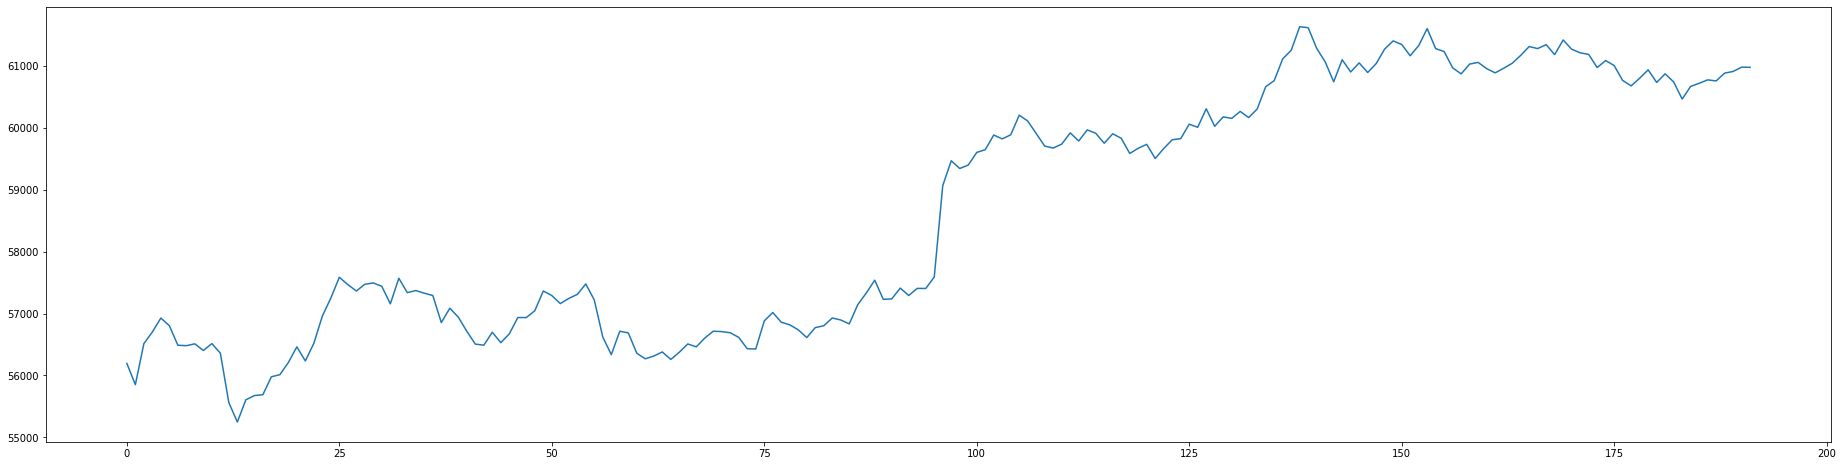

In [ ]:
sns.lineplot(x=range(0,len(closes)),y=closes,legend='auto')
# gts,gks,gssa,gssb,gcs
# sns.lineplot(x=range(0,len(gts)),y=gts)
# sns.lineplot(x=range(0,len(gks)),y=gks)
# sns.lineplot(x=range(0,len(gssa)),y=gssa)
# sns.lineplot(x=range(0,len(gssb)),y=gssb)
# sns.lineplot(x=range(0,len(gcs)),y=gcs)

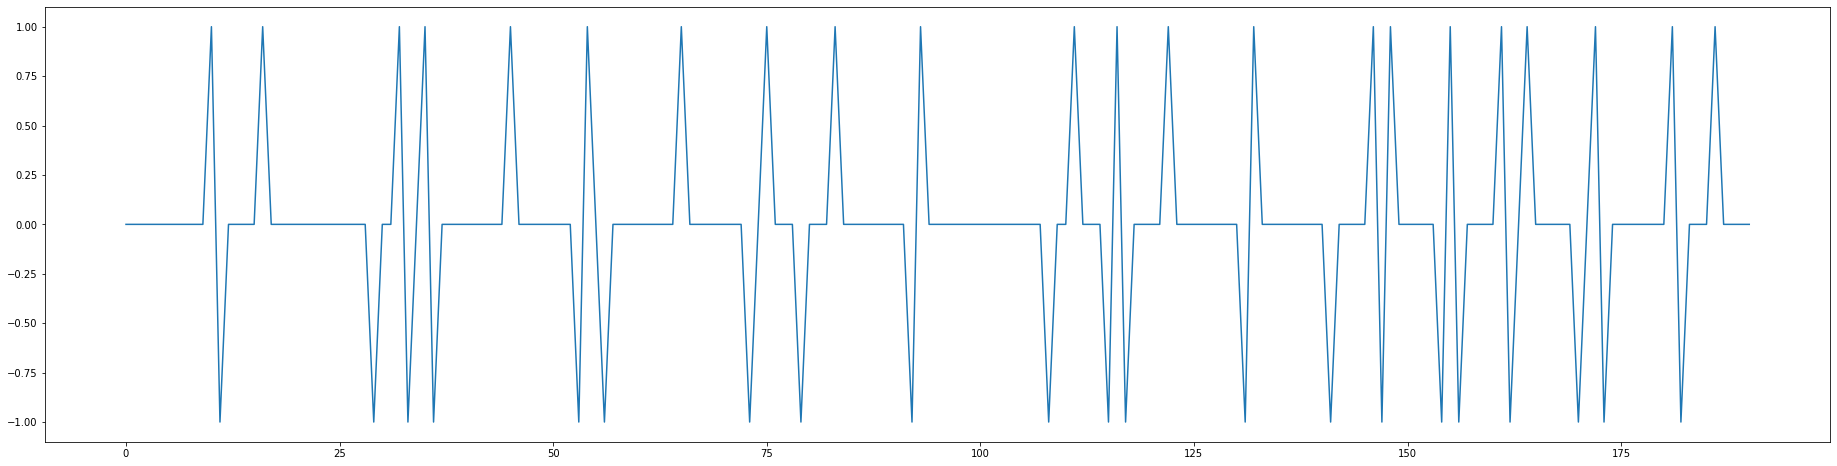

In [ ]:
sns.lineplot(x=range(0,len(signals)),y=signals)
# sns.lineplot(x=range(0,len(timestamps)),y=timestamps)

671


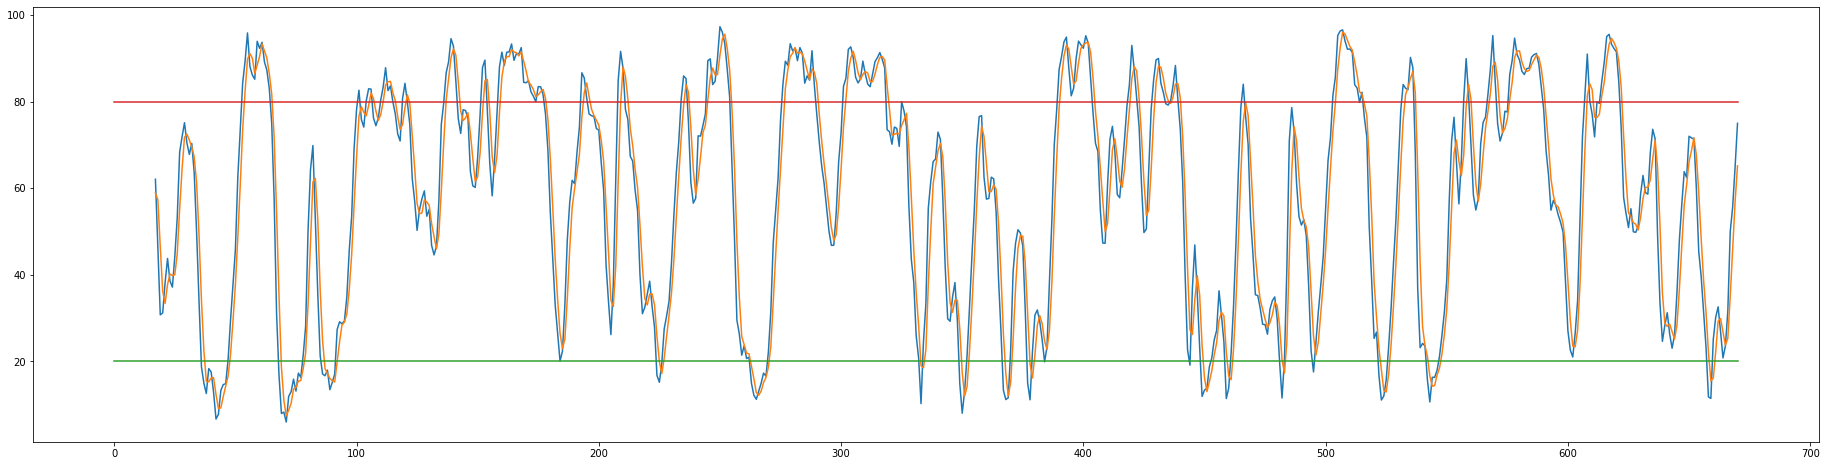

In [ ]:
sns.lineplot(x=range(0,len(tempk)),y=tempk)
sns.lineplot(x=range(0,len(tempd)),y=tempd)
sns.lineplot(x=range(0,len(tempd)),y=20)
sns.lineplot(x=range(0,len(tempd)),y=80)
print(len(signals))